In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

RSEED = 15

from sklearn import set_config
set_config(display='diagram')

In [2]:
bcn = pd.read_csv('../data/df_modelling.csv')

In [3]:
bcn.head()

,Unnamed: 0,id,name,description,neighborhood_overview,picture_url,host_id,host_name,host_since,host_location,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,host_type,suspicious_or_not
0,0,13977576,Habitación individual es Barcelona,Mi alojamiento es bueno para aventureros y via...,NaN,https://a0.muscache.com/pictures/7a6e9767-bd4e...,64903899,Carolina,2016-03-29,"Paris, France",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,private,1
1,1,42105584,Habitación M&D,<b>License number</b><br />Exempt,NaN,https://a0.muscache.com/pictures/7342e586-6ea5...,333969184,Midian,2020-02-06,"Barcelona, Spain",...,NaN,NaN,NaN,NaN,NaN,NaN,Exempt,f,private,1
2,2,33727898,Spacious and bright apartment next to Plaza Es...,Hi friends! Welcome to this apartment located ...,The apartment is located in the Eixample quart...,https://a0.muscache.com/pictures/44066458-5997...,251710733,Magda,2019-03-28,NaN,...,4.97,4.97,5.00,5.00,4.83,4.73,HUTB-008684,f,private,1
3,3,44995311,"Single Room, City Center, Private Bathroom",Goya Hostel is a hostel located in the center ...,"The Eixample, which translates as ""widening"" b...",https://a0.muscache.com/pictures/af651bc2-8dff...,363074093,Hostal,2020-08-18,"Barcelona, Spain",...,4.91,4.73,4.91,4.64,4.91,4.73,HUTB-265656,t,commercial,0
4,4,15763812,HABITACIÓN PLAZA ESPAÑA,"Lugares de interés: Poble Espanyol, CaixaForum...",NaN,https://a0.muscache.com/pictures/1bccbbbc-4b78...,101927904,James,2016-10-31,"Barcelona, Spain",...,4.90,4.94,4.96,4.67,4.88,4.60,Exempt,t,private,1


In [4]:
missing = pd.DataFrame(bcn.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/bcn.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
name,6,0.05
description,55,0.49
neighborhood_overview,4480,39.51
host_name,2,0.02
host_since,2,0.02
host_location,2502,22.06
host_about,4075,35.93
host_response_time,2048,18.06
host_response_rate,2048,18.06
host_acceptance_rate,1685,14.86


In [5]:
#drop columns with all NaN values
df_bl = bcn.drop(['bathrooms', 'calendar_updated'], axis=1)

In [6]:
#drop some columns which we won't use
df_bl.drop(['Unnamed: 0', 'id', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_id', 'host_name', 'host_location',
       'host_about', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'bathrooms_text', 'beds', 'amenities', 'host_total_listings_count', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'host_verifications' ], axis=1, inplace=True)

In [7]:
#check if those with NaN in many host related columns are always the same two
host_nans = df_bl[df_bl['host_since'].isna()]
host_nans

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,room_type,...,bedrooms,price,minimum_nights,maximum_nights,has_availability,number_of_reviews,license,instant_bookable,host_type,suspicious_or_not
3465,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,Eixample,Private room,...,1.0,$50.00,2,1125,t,1,NaN,f,private,1
11104,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,Les Corts,Private room,...,1.0,$50.00,1,1125,t,0,NaN,f,private,1


In [8]:
# since they are, we delete them
df_bl=df_bl.dropna(subset=['host_since'])

## change some dtypes

In [9]:
# hoste_since to datetime
df_bl['host_since']= pd.to_datetime(df_bl['host_since'])

In [10]:
# price to float
df_bl['price'] = df_bl['price'].str[1:]
df_bl['price'] = df_bl['price'].str.replace(',','')
df_bl['price'] = pd.to_numeric(df_bl['price'])

In [11]:
# host_response_rate and host_acceptance_rate to float
df_bl['host_response_rate'] = df_bl['host_response_rate'].str.rstrip("%").astype(float)/100
df_bl['host_acceptance_rate'] = df_bl['host_acceptance_rate'].str.rstrip("%").astype(float)/100

In [12]:
# some boolean to 0/1
le = LabelEncoder()
df_bl['host_is_superhost'] = le.fit_transform(df_bl['host_is_superhost'])
df_bl['host_has_profile_pic'] = le.fit_transform(df_bl['host_has_profile_pic'])
df_bl['host_identity_verified'] = le.fit_transform(df_bl['host_identity_verified'])
df_bl['has_availability'] = le.fit_transform(df_bl['has_availability'])
df_bl['instant_bookable'] = le.fit_transform(df_bl['instant_bookable'])

In [13]:
# host_listings_count as int
df_bl['host_listings_count'] = df_bl['host_listings_count'].astype(int)

## train test split

In [14]:
X = df_bl.drop('suspicious_or_not', axis=1)
y = df_bl['suspicious_or_not']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [16]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (9070, 20)
X_test shape: (2268, 20)
y_train shape: (9070,)
y_test shape: (2268,)


In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9070 entries, 9627 to 7625
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   host_since                    9070 non-null   datetime64[ns]
 1   host_response_time            7420 non-null   object        
 2   host_response_rate            7420 non-null   float64       
 3   host_acceptance_rate          7719 non-null   float64       
 4   host_is_superhost             9070 non-null   int64         
 5   host_listings_count           9070 non-null   int64         
 6   host_has_profile_pic          9070 non-null   int64         
 7   host_identity_verified        9070 non-null   int64         
 8   neighbourhood_group_cleansed  9070 non-null   object        
 9   room_type                     9070 non-null   object        
 10  accommodates                  9070 non-null   int64         
 11  bedrooms                      87

## Preprocessing

### handling numerical

In [18]:
# define mode of train data for imputation
hrt_mode = X_train['host_response_time'].mode()
# define mean of train data for imputation
hrr_mean = X_train['host_response_rate'].mean()
# define mean of train data for imputation
har_mean = X_train['host_acceptance_rate'].mean()
# define mode of train data for imputation
br_mode = X_train['bedrooms'].mode()

In [19]:
# apply both on train and test data
X_train = X_train.fillna(value = {'host_response_time':'within an hour', 'host_response_rate': 0.94,'host_acceptance_rate': 0.89,'bedrooms':1.0})
X_test = X_test.fillna(value = {'host_response_time':'within an hour', 'host_response_rate': 0.94,'host_acceptance_rate': 0.89,'bedrooms':1.0})

In [20]:
def license(license):
    if 'HUTB' in license:
        return 1
    if 'HB' in license:
        return 1
    if 'AJ' in license:
        return 1
    elif 'exempt' in license.lower():
        return 0
    else:
        return 0

In [21]:
X_train['license'] = X_train['license'].fillna('no')
X_test['license'] = X_test['license'].fillna('no')

In [22]:
X_train['license'] = X_train.apply(lambda row: license(row['license']), axis=1)
X_test['license'] = X_test.apply(lambda row: license(row['license']), axis=1)

### handling categorical

In [23]:
cat_features = list(X_train.columns[X_train.dtypes==object])

In [24]:
cat_features

['host_response_time',
 'neighbourhood_group_cleansed',
 'room_type',
 'host_type']

In [25]:
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [26]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features)
])

## Baseline Model Log Reg

In [27]:
pipe_logreg_bl = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [28]:
y_train_predicted_bl = cross_val_predict(pipe_logreg_bl, X_train, y_train, cv=5)

In [29]:
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_bl)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_bl)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_bl)))

Cross validation scores:
-------------------------
Accuracy: 0.78
Recall: 0.80
Precision: 0.74


In [30]:
param_logreg_bl = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag'],
               }

grid_logreg_bl = GridSearchCV(pipe_logreg_bl, param_grid=param_logreg_bl, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

In [31]:
grid_logreg_bl.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johann

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['host_response_time',
                                                                          'neighbourhood_group_cleansed',
                                                                          'room_type',
                                                                          'host_type'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                         'logreg__penalty': ('l1', 'l2'),
                         'logreg__solver': ['liblinear', 'lbfgs', 'sag']},
             scoring='precision', verbose=5)

In [32]:
print('Best score:\n{:.2f}'.format(grid_logreg_bl.best_score_))
print("Best parameters:\n{}".format(grid_logreg_bl.best_params_))

Best score:
0.76
Best parameters:
{'logreg__C': 0.001, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}


In [33]:
baselinemodel = grid_logreg_bl.best_estimator_
baselinemodel

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('logreg', LogisticRegression(C=0.001, max_iter=1000))])

In [34]:
y_test_predicted_bl = baselinemodel.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_bl)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_bl)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_bl)))

Accuracy: 0.79
Recall: 0.81
Precision: 0.75


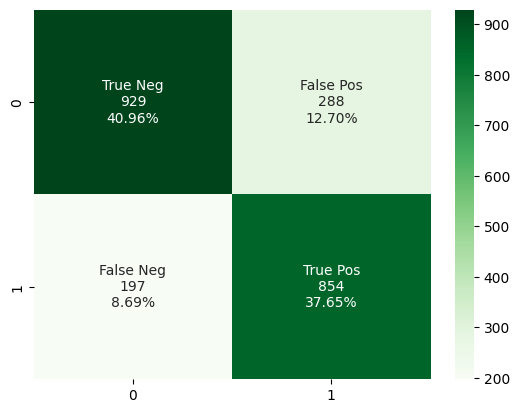

In [35]:
cfm_bl = confusion_matrix(y_test, y_test_predicted_bl)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_bl.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_bl.flatten()/np.sum(cfm_bl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_bl, annot=labels, fmt='', cmap='Greens');

In [36]:
y_test_proba_bl = baselinemodel.predict_proba(X_test)

In [37]:
y_test_proba_bl = y_test_proba_bl[:,1]

In [38]:
bl_auc = roc_auc_score(y_test, y_test_proba_bl)
bl_auc

0.8439108350070794

In [39]:
fprbl, tprbl, thresholdsbl = roc_curve(y_test, y_test_proba_bl)

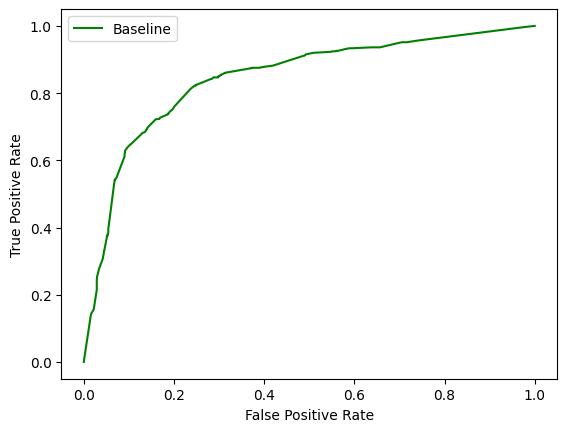

In [40]:
from matplotlib import pyplot
pyplot.plot(fprbl, tprbl, label='Baseline', color='green')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

# Modelling

## Random Forest

In [52]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('randfor', RandomForestClassifier())
])

y_train_predicted_rf = cross_val_predict(pipe_logreg_rf, X_train, y_train, cv=5)

print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_rf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_rf)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_rf)))

Cross validation scores:
-------------------------
Accuracy: 0.78
Recall: 0.72
Precision: 0.79


In [55]:
# param_rf = {'randfor__n_estimators':[100, 500, 1000, 1500, 2000],
#                 'randfor__min_samples_split': [2, 5, 10, 15, 20],
#                 'randfor__max_depth': [10,20,50,80,100],
#                 'randfor__max_features': ['auto', 'sqrt'],
#                 'randfor__min_samples_leaf' : [1,2,4],
#                 'randfor__bootstrap': [True, False],
#               }

# grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=5, scoring='precision', 
#                            verbose=5, n_jobs=-1)

# grid_rf.fit(X_train, y_train)



Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.795 total time=   2.0s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.760 total time=   4.0s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.785 total time=   7.8s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=1000;, score=0.786 total time=   3.8s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=100;, score=0.781 total time=   0.4s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.751 total time=   2.1s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1500;, score=0.785 total time=   5.8s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=100;, score=0.804 total time=   0.4s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=1

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=100;, score=0.790 total time=   0.4s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.775 total time=   4.0s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1500;, score=0.760 total time=   5.8s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=500;, score=0.775 total time=   1.8s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


rt, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1500;, score=0.775 total time=   8.1s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.760 total time=  11.1s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=1500;, score=0.771 total time=   8.0s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=1, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.799 total time=   0.6s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=1, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.774 total time=   0.5s
[CV 2/5] END randfor__bootstrap=True, randfor

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.771 total time=   2.0s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.791 total time=   4.0s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.775 total time=   7.8s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=1000;, score=0.773 total time=   4.0s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=100;, score=0.799 total time=   0.4s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.799 total time=   3.9s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1500;, score=0.773 total time=   5.6s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=100;, score=0.751 total time=   0.4s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.775 total time=   2.1s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1500;, score=0.808 total time=   5.9s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.773 total time=   7.8s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=1500;, score=0.775 total time=   5.9s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=100;, score=0.775 total time=   0.5s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.769 total time=   4.1s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.795 total time=   7.9s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=1000;, score=0.775 total time=   4.1s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=100;, score=0.807 total time=   0.4s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.773 total time=   2.0s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1500;, score=0.775 total time=   5.8s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.760 total time=   8.1s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=2000;, score=0.759 total time=  10.5s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.790 total time=  10.3s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_estimators=500;, score=0.773 total time=   2.6s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_estimators=1000;, score=0.750 total time=   5.3s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_estima

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_estimators=2000;, score=0.773 total time=  10.1s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=1500;, score=0.776 total time=   7.5s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=2000;, score=0.758 total time=  10.1s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=1500;, score=0.747 total time=   8.2s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estima

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=1500;, score=0.750 total time=   8.2s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.753 total time=   0.5s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.776 total time=   2.5s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=1000;, score=0.790 total time=   5.1s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimat

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estimators=1500;, score=0.756 total time=   7.4s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.761 total time=   0.5s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.747 total time=   0.5s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=500;, score=0.794 total time=   2.5s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimat

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=100;, score=0.761 total time=   0.5s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.790 total time=   2.5s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.758 total time=   2.6s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=1500;, score=0.790 total time=   7.5s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=2

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.778 total time=   2.6s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=1000;, score=0.778 total time=   5.1s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.790 total time=  10.1s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estimators=500;, score=0.741 total time=   2.5s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estima

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=500;, score=0.790 total time=   2.7s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=500;, score=0.756 total time=   2.6s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=1500;, score=0.790 total time=   7.6s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=2000;, score=0.738 total time=  10.0s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=2000;, score=0.790 total time=  10.0s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.741 total time=   2.6s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.747 total time=   5.2s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.778 total time=  10.7s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimator

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=500;, score=0.790 total time=   2.8s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=1000;, score=0.790 total time=   5.6s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=1500;, score=0.758 total time=   8.2s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=100;, score=0.781 total time=   0.7s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimato

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=1000;, score=0.776 total time=   4.6s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=1500;, score=0.791 total time=   6.9s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=100;, score=0.777 total time=   0.5s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=100;, score=0.758 total time=   0.5s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimator

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=1500;, score=0.765 total time=   8.1s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.786 total time=   0.5s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.794 total time=   2.6s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.765 total time=   2.5s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimato

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.794 total time=   4.4s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.771 total time=   9.0s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=1000;, score=0.771 total time=   4.4s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=1500;, score=0.789 total time=   7.1s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimato

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=500;, score=0.765 total time=   2.5s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=500;, score=0.766 total time=   2.5s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=1500;, score=0.799 total time=   7.6s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=2000;, score=0.791 total time=   9.9s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=20, randfor__n_estima

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.794 total time=   2.4s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.758 total time=   4.9s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.789 total time=   9.5s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=1000;, score=0.794 total time=   4.8s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_estimators=500;, score=0.793 total time=   2.4s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_estimators=1000;, score=0.776 total time=   4.8s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_estimators=1500;, score=0.791 total time=   7.1s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.776 total time=   0.5s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estima

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=100;, score=0.804 total time=   0.5s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=100;, score=0.791 total time=   0.5s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=500;, score=0.775 total time=   2.6s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=1000;, score=0.775 total time=   5.2s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=1

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estimators=1000;, score=0.771 total time=   4.6s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estimators=1500;, score=0.794 total time=   6.9s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.775 total time=   0.5s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.756 total time=   0.5s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=80, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estima

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimators=100;, score=0.790 total time=   0.5s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimators=100;, score=0.791 total time=   0.5s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.776 total time=   2.6s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.794 total time=   5.3s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimat

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.770 total time=   0.5s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.814 total time=   0.5s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=20, randfor__n_estimators=500;, score=0.783 total time=   2.5s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=20, randfor__n_estimators=1000;, score=0.770 total time=   5.0s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=20, randfor__n_es

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.791 total time=   2.6s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.765 total time=   5.2s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.790 total time=  10.0s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=1000;, score=0.791 total time=   5.0s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estim

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.800 total time=  11.0s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=500;, score=0.814 total time=   2.7s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=1500;, score=0.799 total time=   8.2s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=2000;, score=0.791 total time=  10.8s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=10, randfor__n_esti

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.776 total time=   0.5s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.791 total time=   0.5s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=500;, score=0.776 total time=   2.4s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=1000;, score=0.776 total time=   4.8s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_es

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=1500;, score=0.789 total time=   6.8s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.790 total time=   0.5s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.774 total time=   0.5s
[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.790 total time=   2.3s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_est

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_estimators=2000;, score=0.794 total time=   9.8s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=500;, score=0.791 total time=   2.5s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=1000;, score=0.764 total time=   4.8s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=2000;, score=0.790 total time=   9.3s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_e

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.771 total time=   8.9s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estimators=1000;, score=0.789 total time=   4.5s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estimators=1500;, score=0.758 total time=   6.7s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.755 total time=   0.5s
[CV 2/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=2000;, score=0.790 total time=   9.1s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.755 total time=   2.2s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=1000;, score=0.758 total time=   4.5s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.789 total time=   8.8s
[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_e

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=10, randfor__n_estimators=1500;, score=0.799 total time=   7.0s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.773 total time=   9.0s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=1500;, score=0.775 total time=   6.8s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=2000;, score=0.760 total time=   9.0s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=20, randfor__n

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 4/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=500;, score=0.755 total time=   2.2s
[CV 5/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=1000;, score=0.756 total time=   4.5s
[CV 3/5] END randfor__bootstrap=True, randfor__max_depth=100, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=2000;, score=0.789 total time=   8.8s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.773 total time=   4.7s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_es

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=10, randfor__n_estimators=1500;, score=0.758 total time=   7.1s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=100;, score=0.765 total time=   0.5s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=500;, score=0.799 total time=   2.3s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=500;, score=0.773 total time=   2.2s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_es

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.799 total time=   2.5s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.760 total time=   2.5s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=1500;, score=0.795 total time=   7.1s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.773 total time=   9.3s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estima

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=20, randfor__n_estimators=2000;, score=0.773 total time=   9.0s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimators=1500;, score=0.775 total time=   6.9s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.759 total time=   9.2s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=2000;, score=0.775 total time=   9.2s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_es

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=1000;, score=0.774 total time=   4.4s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=2000;, score=0.775 total time=   9.0s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=1000;, score=0.775 total time=   4.3s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=1500;, score=0.759 total time=   6.7s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_e

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=500;, score=0.772 total time=   2.1s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=1000;, score=0.747 total time=   4.2s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.778 total time=   8.3s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=1000;, score=0.738 total time=   4.1s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estim

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.774 total time=   8.8s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_estimators=1500;, score=0.775 total time=   6.9s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_estimators=2000;, score=0.759 total time=   8.8s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=20, randfor__n_estimators=2000;, score=0.794 total time=   8.6s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=2, randfor__n_

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=5, randfor__n_estimators=2000;, score=0.770 total time=  11.3s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=10, randfor__n_estimators=1000;, score=0.783 total time=   5.4s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=10, randfor__n_estimators=1500;, score=0.814 total time=   8.4s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=100;, score=0.815 total time=   0.6s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=auto, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_e

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.778 total time=   8.4s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estimators=1000;, score=0.772 total time=   4.1s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estimators=2000;, score=0.771 total time=   8.3s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=1000;, score=0.778 total time=   4.1s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=10, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=500;, score=0.783 total time=   2.7s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=1000;, score=0.799 total time=   5.4s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=1, randfor__min_samples_split=15, randfor__n_estimators=1500;, score=0.783 total time=   8.0s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=1, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.770 total time=   0.5s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=1, randfor__min_samples_split=20, randfor__n_e

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=2000;, score=0.794 total time=  10.6s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.790 total time=   2.6s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=1000;, score=0.765 total time=   5.1s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.790 total time=  10.1s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_e

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.775 total time=   9.6s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estimators=1000;, score=0.789 total time=   4.8s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estimators=1500;, score=0.758 total time=   7.2s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.789 total time=   0.5s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=1500;, score=0.777 total time=   7.1s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.758 total time=   9.7s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_estimators=2000;, score=0.794 total time=   9.6s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=500;, score=0.790 total time=   2.4s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=20, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.770 total time=   0.5s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.765 total time=   0.6s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.794 total time=   2.5s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=1000;, score=0.790 total time=   5.1s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_es

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.775 total time=   0.5s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=100;, score=0.763 total time=   0.5s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=500;, score=0.789 total time=   2.4s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_estimators=1000;, score=0.772 total time=   4.7s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=20, randfor__n_es

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.794 total time=   2.6s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.765 total time=   2.6s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=1500;, score=0.794 total time=   7.8s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.790 total time=  10.3s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=sqrt, randfor__min_samples_leaf=2, randfor__min_samples_split=15, randfor__n_e

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.769 total time=   0.5s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.763 total time=   0.5s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.789 total time=   2.4s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=1000;, score=0.789 total time=   4.8s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=50, randfor__max_features=sqrt, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_es

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=1000;, score=0.758 total time=   4.9s
[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=2000;, score=0.790 total time=   9.8s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=1000;, score=0.790 total time=   4.9s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=2000;, score=0.775 total time=   9.7s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=15, randfor__n_e

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimators=1500;, score=0.794 total time=   8.0s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=2, randfor__n_estimators=2000;, score=0.790 total time=  10.8s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=1500;, score=0.775 total time=   8.3s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=2000;, score=0.765 total time=  11.0s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_est

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 3/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=5, randfor__n_estimators=1500;, score=0.790 total time=   7.9s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.794 total time=   0.5s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=100;, score=0.790 total time=   0.6s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_estimators=500;, score=0.775 total time=   2.7s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=2, randfor__min_samples_split=10, randfor__n_est

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=500;, score=0.758 total time=   2.4s
[CV 1/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=1500;, score=0.794 total time=   7.2s
[CV 4/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=5, randfor__n_estimators=2000;, score=0.790 total time=   9.9s
[CV 2/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_estimators=1500;, score=0.772 total time=   7.3s
[CV 5/5] END randfor__bootstrap=False, randfor__max_depth=80, randfor__max_features=auto, randfor__min_samples_leaf=4, randfor__min_samples_split=10, randfor__n_est

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best score:
0.80
Best parameters:
{'randfor__bootstrap': True, 'randfor__max_depth': 80, 'randfor__max_features': 'auto', 'randfor__min_samples_leaf': 2, 'randfor__min_samples_split': 5, 'randfor__n_estimators': 100}


In [57]:
print('Best score:\n{:.2f}'.format(grid_rf.best_score_))
print("Best parameters:\n{}".format(grid_rf.best_params_))

Best score:
0.80
Best parameters:
{'randfor__bootstrap': True, 'randfor__max_depth': 80, 'randfor__max_features': 'auto', 'randfor__min_samples_leaf': 2, 'randfor__min_samples_split': 5, 'randfor__n_estimators': 100}


Best parameters
{'randfor__bootstrap': True, 'randfor__max_depth': 80, 'randfor__max_features': 'auto', 'randfor__min_samples_leaf': 2, 'randfor__min_samples_split': 5, 'randfor__n_estimators': 100}

In [63]:
grid_rf.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('randfor',
                 RandomForestClassifier(max_depth=80, max_features='auto',
                                        min_samples_leaf=2,
                                        min_samples_split=5))])

In [62]:
grid_rf.best_params_

{'randfor__bootstrap': True,
 'randfor__max_depth': 80,
 'randfor__max_features': 'auto',
 'randfor__min_samples_leaf': 2,
 'randfor__min_samples_split': 5,
 'randfor__n_estimators': 100}

In [56]:
randomforest = grid_rf.best_estimator_
randomforest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('randfor',
                 RandomForestClassifier(max_depth=80, max_features='auto',
                                        min_samples_leaf=2,
                                        min_samples_split=5))])

In [58]:
y_test_predicted_rf = randomforest.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_rf)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_rf)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_rf)))

Accuracy: 0.79
Recall: 0.72
Precision: 0.81


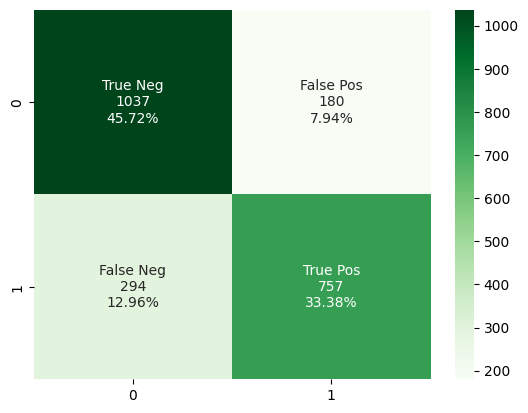

In [59]:
cfm_rf = confusion_matrix(y_test, y_test_predicted_rf)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_rf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_rf.flatten()/np.sum(cfm_bl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_rf, annot=labels, fmt='', cmap='Greens');

In [65]:
y_test_proba_rf = randomforest.predict_proba(X_test)
y_test_proba_rf = y_test_proba_rf[:,1]
rf_auc = roc_auc_score(y_test, y_test_proba_rf)
fprrf, tprrf, thresholdsrf = roc_curve(y_test, y_test_proba_rf)

In [67]:
rf_auc

0.8560798613364272

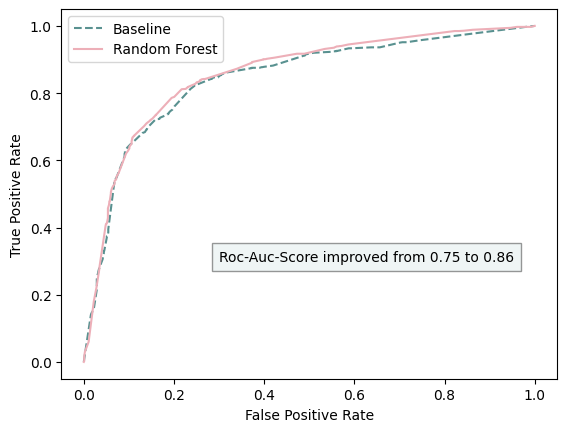

In [66]:
from matplotlib import pyplot
pyplot.plot(fprbl, tprbl, linestyle='--', label='Baseline', color='#599190')
pyplot.plot(fprrf, tprrf, label='Random Forest', color = '#edafb8')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.text(0.3,0.3,'Roc-Auc-Score improved from 0.75 to 0.86', bbox={
        'facecolor': '#D9E8E8', 'alpha': 0.4, 'pad': 5})
pyplot.legend()
pyplot.show()